In [3]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import utils 
import torch
from torch import nn
from torchsummary import summary
from einops import rearrange, reduce, repeat

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="LSTM_AE")





/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [4]:
# import wandb
# wandb.init()


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:

class SpiralDataset(torch.utils.data.Dataset):
    def __init__(self, nTime=72, nBatch=64, seed=0):
        self.data = utils.SynthData.spiral(nTime, nBatch, seed)
        
    def __getitem__(self, idx):
        return self.data[idx, :, :]
        
    def __len__(self):
        return self.data.shape[0]
        
            

class SynthDataModule(pl.LightningDataModule):
    def __init__(self):
        self.prepare_data_per_node = False
        self._log_hyperparams = True
        self.dataset_train = SpiralDataset()
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.dataset_train, batch_size=64, shuffle=True)
        


In [7]:
class EncoderLayer(nn.Module):
    def __init__(self, nFeature=32, dropout=0.1):
        super(EncoderLayer, self).__init__()        
        self.lstm = nn.LSTM(nFeature, nFeature, 1, batch_first=True)
        self.selu = nn.SELU()
        self.dropout = nn.Dropout(dropout)
                
    def forward(self, x, hc=None):   
        # b t f 
        res = x
        if hc is None:
            x, hidden = self.lstm(x)
        else:
            x, hidden = self.lstm(x, hc)
        x = self.selu(x)
        x += res
        x = self.dropout(x)
        return x


class Encoder(nn.Module):
    def __init__(self, nLayer=8, nFeature=32, dropout=0.1):
        super(Encoder, self).__init__()
        self.seq = nn.Sequential()
        for i in range(nLayer):
            self.seq.add_module(f'lstm{i}', EncoderLayer(nFeature=nFeature))
            
    def forward(self, x):
        x = self.seq(x)        
        return x
        
# model = Encoder()
# model(torch.rand(3, 10, 32)).shape

In [8]:

class DecoderLayer(nn.Module):
    def __init__(self, nFeature=32, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.lstm = nn.LSTM(nFeature, nFeature, 1, batch_first=True)
        self.selu = nn.SELU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hc=None):   
        # b t f 
        res = x
        if hc is None:
            x, hidden = self.lstm(x)
        else:
            x, hidden = self.lstm(x, hc)
        x = self.selu(x)
        x += res
        x = self.dropout(x)
        return x
    

class Decoder(nn.Module):
    def __init__(self, nLayer=8, nFeature=32, dropout=0.1):
        super(Decoder, self).__init__()
        self.seq = nn.Sequential()
        for i in range(nLayer):
            self.seq.add_module(f'lstm{i}', DecoderLayer(nFeature=nFeature))
            
    def forward(self, x):
        x = self.seq(x)        
        return x  
    
# model = Decoder()
# model(torch.rand(5, 3, 32)).shape

In [14]:
class TrajNet(pl.LightningModule):
    def __init__(self, nhidden=16, nLayer=8, nFeature=32, dropout=0.02):
        super(TrajNet, self).__init__()

        # Encoder
        self.conv_enc = nn.Conv1d(2, nFeature, kernel_size=1)
        self.dropout_enc = nn.Dropout(dropout)
        self.encoder = Encoder(
            nLayer=nLayer, nFeature=nFeature, dropout=dropout)

        # Hidden
        self.preZ = nn.Linear(nFeature, nhidden)
        self.postZ = nn.Linear(nhidden, nFeature)

        # Decoder
        self.conv_dec1 = nn.Conv1d(nhidden, nFeature, kernel_size=1)
        self.decoder = Decoder(
            nLayer=nLayer, nFeature=nFeature, dropout=dropout)
        self.conv_dec2 = nn.Conv1d(nFeature, 2, kernel_size=1)

    @staticmethod
    def reparameterize(mu, log_var, nTime):
        mu = repeat(mu, 'b f -> b t f', t=nTime)
        std = torch.exp(0.5*log_var)  # standard deviation
        std = repeat(std, 'b f -> b t f', t=nTime)
        sample = torch.normal(mu, std) # b f
        # sample = repeat(sample, 'b f -> b t f', t=nTime)
        return sample

    def forward(self, x):
        # x: b t f
        nTime = x.shape[1]
        # --------------------------------- encoding --------------------------------- #
        x = rearrange(x, 'b t f -> b f t')
        x = self.conv_enc(x)
        # x = self.dropout_enc(x)
        x = rearrange(x, 'b f t -> b t f')
        x = self.encoder(x)
        x = x[:, -1, :]

        # ---------------------------------- hidden ---------------------------------- #
        x = self.preZ(x)
        z = torch.tanh(x)
        y = self.postZ(z)
        y = torch.tanh(z)
        y = repeat(y, 'b f -> b t f', t=nTime)

        # --------------------------------- decoding --------------------------------- #
        y = rearrange(y, 'b t f -> b f t')
        y = self.conv_dec1(y)
        y = rearrange(y, 'b f t -> b t f')
        y = self.decoder(y)
        # y = y[:, :, 0:2]
        y = rearrange(y, 'b t f -> b f t')
        y = self.conv_dec2(y)
        y = rearrange(y, 'b f t -> b t f')

        return y
    
    def training_step(self, batch, batch_idx):
        y = self.forward(batch)
        loss = torch.nn.functional.mse_loss(y, batch)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# model = TrajNet()
# # b t f
# d = torch.rand(5, 3, 2)
# d = model.forward(d)


In [15]:
dataMD = SynthDataModule()
model = TrajNet().double()


In [49]:
trainer = pl.Trainer(max_epochs=100000, logger=wandb_logger, log_every_n_steps=10)
trainer.fit(model, dataMD)
# trainer.optimizers[0]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /home/acercyc/projects/Keio Testing_analysis/src/VAE/3g58jpq0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type    | Params
----------------------------------------
0 | conv_enc    | Conv1d  | 96    
1 | dropout_enc | Dropout | 0     
2 | encoder     | Encoder | 67.6 K
3 | preZ        | Linear  | 528   
4 | postZ       | Linear  | 544   
5 | conv_dec1   | Conv1d  

Training: 0it [00:00, ?it/s]

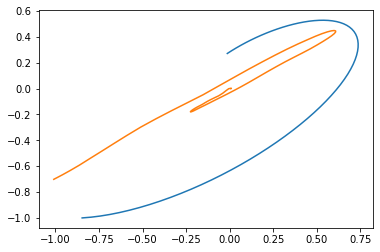

In [101]:
x = dataMD.dataset_train[np.random.randint(0, len(dataMD.dataset_train))]
model.eval()
y = model(torch.from_numpy(x).unsqueeze(0))
y = y.detach().numpy().squeeze()
fig, ax = plt.subplots(1, 1)
ax.plot(x[:, 0], x[:, 1], '-')
ax.plot(y[:, 0], y[:, 1], '-')b


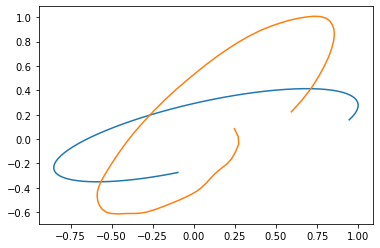

In [152]:
dataset_eval = SpiralDataset(seed=1)
x = dataset_eval[np.random.randint(0, len(dataset_eval))]
model.eval()
y = model(torch.from_numpy(x).unsqueeze(0))
y = y.detach().numpy().squeeze()
fig, ax = plt.subplots(1, 1)
ax.plot(x[:, 0], x[:, 1], '-')
ax.plot(y[:, 0], y[:, 1], '-')
